# Master's Thesis: Investigating Maximum Rainfall Trends in Colorado

<b>Institution:</b> University of Georgia <br>
<b>Department:</b> Statistics <br>
<b>Student:</b> Jeremy Mulcahey <br>
<b>Advisor:</b> Dr. Lynne Seymour <br>
<b>File:</b> 02_Boulder<br>
<b>Last Edit:</b> 7/4/2016

Section 0: Preparing data <br>
Section 1: Distribution of Max Precipitation and Trends<br>
Section 2: Parameter Estimation, Distribution, and Trends

##  Section 0: Preparing data

In [1]:
require(fitdistrplus); # required for parameter estimation
require(caTools);      # required for smoothing
require(repr);         # required for resizing plots in IRKernel
require("IRdisplay");  # graphic embedding
require(MASS);         # testing

Loading required package: fitdistrplus
Warning message:
: package 'fitdistrplus' was built under R version 3.3.1Loading required package: MASS
Loading required package: survival
Loading required package: caTools
Loading required package: repr
Loading required package: IRdisplay


In [2]:
# establish working directorys
setwd("C:/Users/flunk_000/Desktop/UGA/Master'sThesis/")

Data files for individual station names.

In [3]:
data = read.csv(file = "data/BOULDER_MonMax_GHCN.csv", head=T)

Adjust the data for later use.

In [4]:
# Create an index as x - used as needed
month = seq(1,nrow(data),by=1)
data = cbind(data,month)

# first year of the data (changes by station name)
firstYear = data$YEAR[1]

# station name for plotting
stationName = as.character(data$STATION_NAME[1])

# -999 messed with the plotting - change to NA
data[data==-999] = NA

sum(is.na(data)) #print number of missing values

[1] 165

Check number of years in the data set.

In [2]:
data$YEAR[nrow(data)]-firstYear

ERROR: Error in data$YEAR: object of type 'closure' is not subsettable


Make a data frame of all the 10 year periods following the first year for data collected at the station.

In [6]:
#create the first decade (first year and the following 9 years)
max_PRCP = data.frame(data[which(data$YEAR < (firstYear + 10)),6])

# add all the subsequent decades to the data frame incrementing by 1 year at a time
# i.e. 1896-1905, 1897-1906, etc
for(year in c((data$YEAR[1] + 1):2005)){
    max_PRCP = cbind(max_PRCP,data[which(data$YEAR >= year & data$YEAR < year+10),6])
}

# name the columns as the first year of the observed 10 year periods
colnames(max_PRCP) = as.character(c(firstYear:2005))

# set the missing values to NA
max_PRCP[max_PRCP==-999] = NA

## Section 1: Distribution of Max Precipitation and Trends

In [1]:
data2012 = data[which(data$YEAR<2014),]

ERROR: Error in data$YEAR: object of type 'closure' is not subsettable


In [7]:
options(repr.plot.width=5, repr.plot.height=5) #reduces the plot sizes

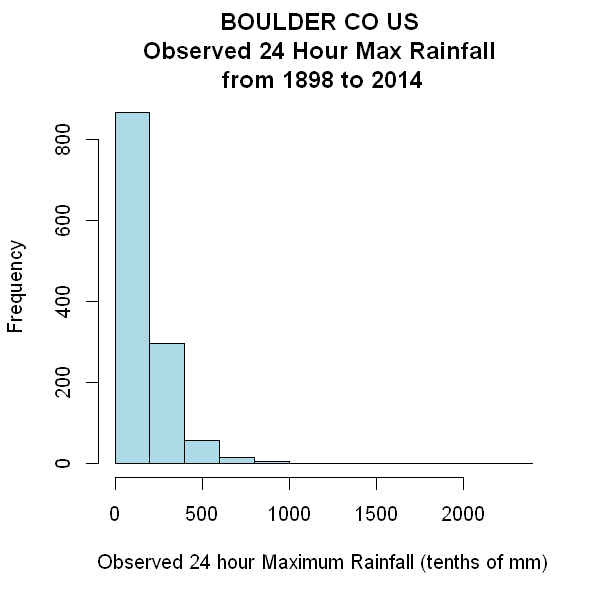

In [8]:
hist(data$Max.PRCP, xlab = sprintf("Observed 24 hour Maximum Rainfall (tenths of mm)",
                                   firstYear), main=sprintf("%s \nObserved 24 Hour Max Rainfall \nfrom %i to 2014",
                                   stationName,firstYear),col="lightblue")        

### Maximum Rainfall Trends

In [9]:
# create for maximum rainfall
maxTS = ts(data$Max.PRCP)

# create regression line
reg = lm(Max.PRCP. ~ month, data=data)

Slope of the regression line:

In [10]:
round(reg$coefficients[2],3)

month 
0.031

In [11]:
length(data$MONTH)*round(reg$coefficients[2],3)

month 
43.524

Although month isn't very predictive of maximum observed rainfall, there does appear to be an increase over the time data was collected.

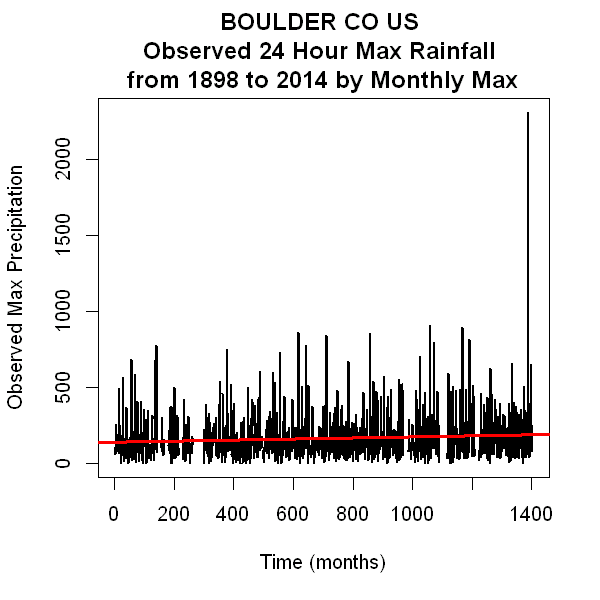

In [12]:
plot(maxTS, xlab = "Time (months)", col = "black", lwd=2, ylab = "Observed Max Precipitation", 
     main=sprintf("%s \nObserved 24 Hour Max Rainfall \nfrom %i to 2014 by Monthly Max", stationName,firstYear))
abline(reg, col="red", lwd=3)

In the time series plot, we also see that the peaks are gradually increasing over time, which is of specific interest to people working with maximum rainfall estimation. These increasing peaks have been wreaking havoc on Texas and the Eastern US this year. (Template statement - change as needed for individual stations).

Produce smoothed plots to get a better understanding of the trends.

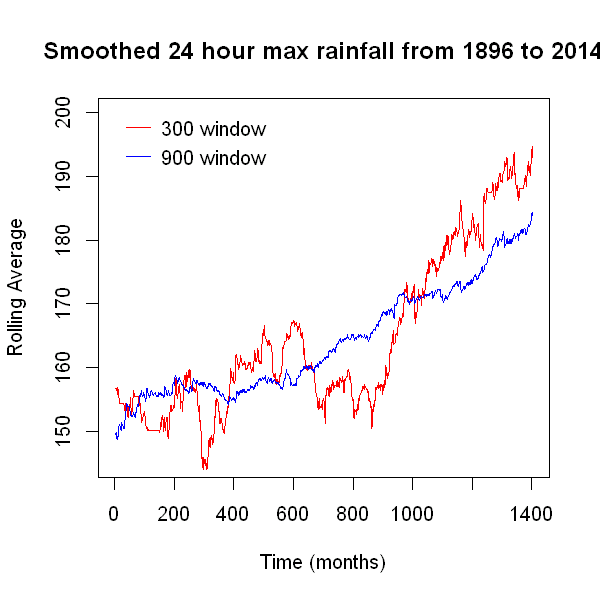

In [35]:
rollSmall = runmean(data$Max.PRCP., 300)
rollLarge = runmean(data$Max.PRCP., 900)
plot(rollSmall, type="l", ylim = c(145,200), xlab = "Time (months)", 
    ylab = "Rolling Average", col = 2, main="Smoothed 24 hour max rainfall from 1896 to 2014")
    points(rollLarge, type="l", col=4)
    legend(0,200, c("300 window","", "900 window"), col=c(2,0,4), lty=c(1,0,1), bty="n")

While the data shows a slight decrease in average rainfall at the tail end of our data (2014), the long term trend shows that average rainfall has been increasing. Empirically, we have had a wet year in 2016 that we would expect to match/exceed the long term observed increase in average maximum rainfall.(Template statement - change as needed for individual stations)

## Section 2: Parameter Estimation, Distribution, and Trends

In [14]:
mle = data.frame(alpha = double(),
                 theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   gamma1 = fitdist(as.vector(testDist),"gamma",method = "mle")
   mle[i,1] = gamma1$estimate[1]
   mle[i,2] = gamma1$estimate[2]
   
   gof = gofstat(gamma1)
   mle[i,3] = gof$ks
   mle[i,4] = gof$kstest
   mle[i,5] = gof$cvm
   mle[i,6] = gof$cvmtest
   mle[i,7] = gof$ad
   mle[i,8] = gof$adtest
}

mle["invTheta"] = 1/(mle$theta)
mle["mean"] = mle$invTheta*mle$alpha
mle["var"] = mle$alpha*(mle$invTheta^2)
mle["sd"] = sqrt(mle$var)

Plot the estimated distributions over time and create a gif (done in R/windows).

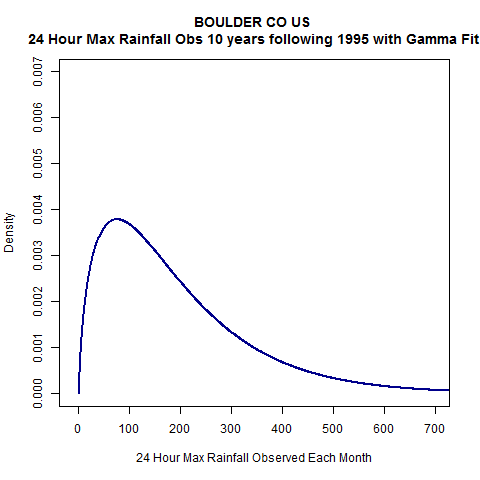

In [36]:
# display one pane of the gif - change per station
display_png(file = "plots/baseRSlideShowBoulder/0098plot.png")

Check distribution of estimated means - should be approximately normal.

In [16]:
shapiro.test(mle$mean)


	Shapiro-Wilk normality test

data:  mle$mean
W = 0.98347, p-value = 0.2015


Obtain values for histogram.

In [17]:
meanSum = summary(mle$mean)
meanDist = fitdistr(mle$mean,"normal")
x = seq(meanSum[1],meanSum[6],length = 10000)

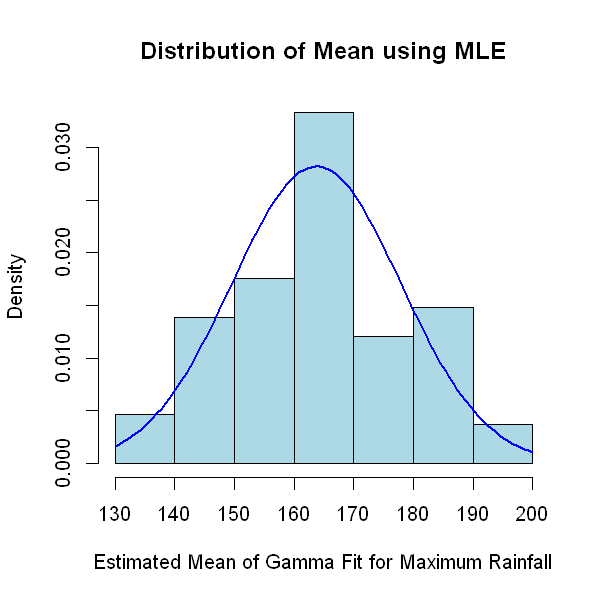

In [18]:
# distribution of mean parameter
hist(mle$mean, freq = FALSE, col = "light blue", main = "Distribution of Mean using MLE", 
     xlab = "Estimated Mean of Gamma Fit for Maximum Rainfall")

# normal fit using estimated parameters
curve(dnorm(x,meanDist$estimate[1],meanDist$estimate[2]), col="blue", lwd=2,add=TRUE)

Look at the mean over time.

In [38]:
time = seq(firstYear, 2005)

In [39]:
meanTS = ts(mle$mean, start=c(firstYear))
reg = lm(mle$mean ~ time)

In [40]:
round(reg$coefficients[2],3)

time 
0.298

In [41]:
length(mle$mean)*round(reg$coefficients[2],3)

time 
32.184

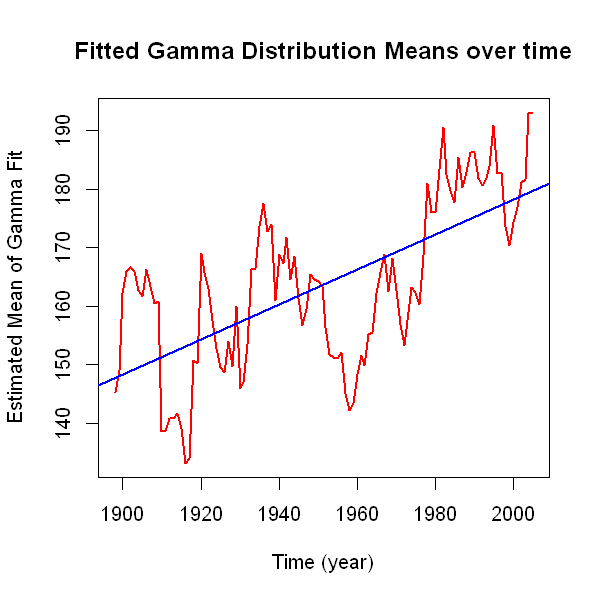

In [42]:
plot(meanTS, type="l", col="red", lwd = 1.75,
     xlab = "Time (year)", ylab = "Estimated Mean of Gamma Fit", 
     main = "Fitted Gamma Distribution Means over time")
abline(reg, col="blue", lwd=2)

Parameter estimation looks good since it matches the smoothed averages.

Repeat for the variances.

In [43]:
shapiro.test(mle$var)


	Shapiro-Wilk normality test

data:  mle$var
W = 0.9542, p-value = 0.0009469


In [44]:
varSum = summary(mle$var)
varDist = fitdistr(mle$var,"normal")
x = seq(varSum[1],varSum[6],length = 10000)

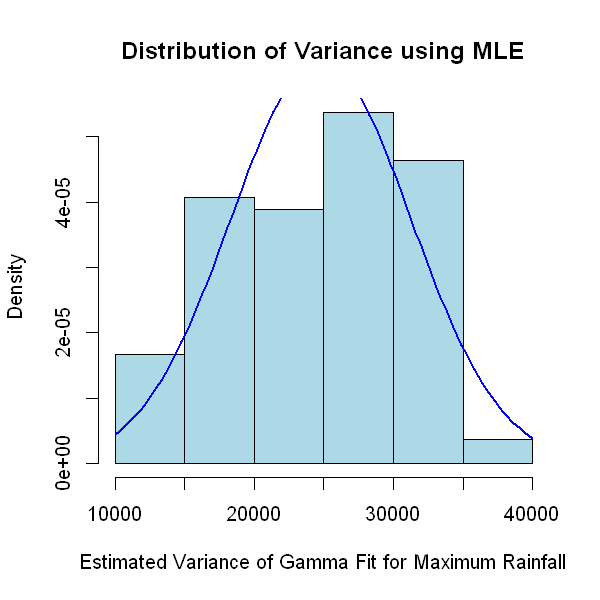

In [45]:
# distribution of mean parameter
hist(mle$var, freq = FALSE, col = "light blue", main = "Distribution of Variance using MLE", 
     xlab = "Estimated Variance of Gamma Fit for Maximum Rainfall")

# normal fit using estimated parameters
curve(dnorm(x,varDist$estimate[1],varDist$estimate[2]), col="blue", lwd=2,add=TRUE)

In [46]:
varTS = ts(mle$var, start=c(firstYear))
reg = lm(mle$var ~ time)

In [47]:
round(reg$coefficients[2],3)

time 
-99.304

In [48]:
length(mle$var)*round(reg$coefficients[2],3)

time 
-10724.83

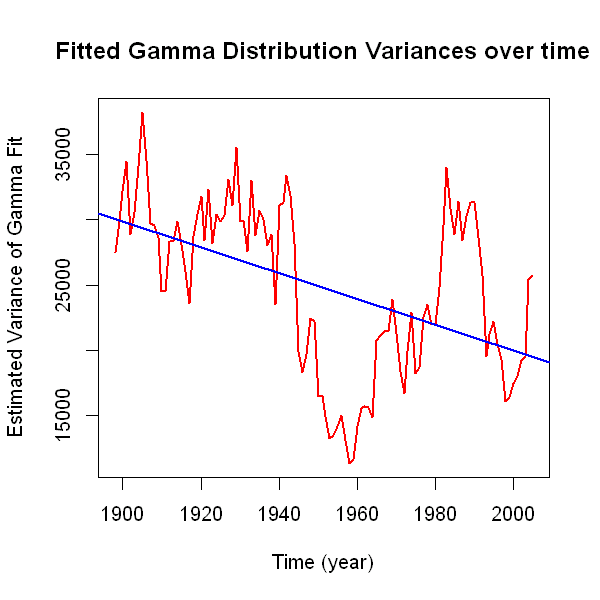

In [50]:
plot(varTS, type="l", col="red", lwd = 1.75,
     xlab = "Time (year)", ylab = "Estimated Variance of Gamma Fit", 
     main = "Fitted Gamma Distribution Variances over time")
abline(reg, col="blue", lwd=2)

In case the distributions aren't making sense, check the number of times the Gamma distribution fit passed the KS test.

In [52]:
table(mle$KStest)


not rejected     rejected 
          71           37 